# HIGH LEVEL

## Load Data

In [1]:
import pandas as pd
from pandas.api.types import CategoricalDtype
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn import pipeline
from prophet import Prophet

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('IWC_Work_Orders_Extract.csv')

# change valid date columns to datetime
dates = ['EXECUTION_START_DATE', 'EXECUTION_FINISH_DATE', 'EQUIP_START_UP_DATE', 'EQUIP_VALID_FROM', 'EQUIP_VALID_TO']

for col in dates:
    df[col] = pd.to_datetime(df[col], errors='coerce')

In [3]:
df.head()

,ORDER_ID,PLANT_ID,PRODUCTION_LOCATION,EXECUTION_START_DATE,EXECUTION_FINISH_DATE,ACTUAL_START_TIME,ACTUAL_FINISH_TIME,ACTUAL_WORK_IN_MINUTES,MAINTENANCE_PLAN,MAINTENANCE_ITEM,MAINTENANCE_ACTIVITY_TYPE,ORDER_DESCRIPTION,MAINTENANCE_TYPE_DESCRIPTION,FUNCTIONAL_LOC,FUNCTIONAL_AREA_NODE_1_MODIFIED,FUNCTIONAL_AREA_NODE_2_MODIFIED,FUNCTIONAL_AREA_NODE_3_MODIFIED,FUNCTIONAL_AREA_NODE_4_MODIFIED,FUNCTIONAL_AREA_NODE_5_MODIFIED,EQUIPMENT_ID,EQUIPMENT_DESC,EQUIP_CAT_DESC,EQUIP_START_UP_DATE,EQUIP_VALID_FROM,EQUIP_VALID_TO
0,705642457,G812,ROMA,2024-05-04,2024-05-12,06:00:00.000,23:04:08.000,390.0,NaN,NaN,Unplanned,L2 GEARBOX LEAK (SEE ATTACHED),Corrective Maintenance Order,G812-PRD-L15-L03-L030-020,PRODUCTION,G812 PRD FILLER_ROTARY_CAN,G812 PRD FILLER_ROTARY_CAN LINE 3,CONVEYOR,FULL CAN CONVEYOR,300126812.0,FULL CAN CONVEYOR (FC41B),Machines,2020-04-22,2020-02-10,NaT
1,704191697,G812,ROMA,2022-09-13,2022-09-13,06:00:00.000,17:17:24.000,420.0,NaN,NaN,Unplanned,LINE 3 CONVEYOR AT CAN CODER,Corrective Maintenance Order,G812-PRD-L15-L03-L030-020,PRODUCTION,G812 PRD FILLER_ROTARY_CAN,G812 PRD FILLER_ROTARY_CAN LINE 3,CONVEYOR,FULL CAN CONVEYOR,300126812.0,FULL CAN CONVEYOR (FC41B),Machines,2020-04-22,2020-02-10,NaT
2,704466547,G812,ROMA,2022-12-21,2022-12-21,07:00:00.000,07:00:00.000,30.0,NaN,NaN,Unplanned,BROKEN CONVEYOR RAIL,Corrective Maintenance Order,G812-PRD-L15-L03-L030-020,PRODUCTION,G812 PRD FILLER_ROTARY_CAN,G812 PRD FILLER_ROTARY_CAN LINE 3,CONVEYOR,FULL CAN CONVEYOR,300126812.0,FULL CAN CONVEYOR (FC41B),Machines,2020-04-22,2020-02-10,NaT
3,703834477,G812,ROMA,2022-07-04,2022-07-04,06:00:00.000,06:00:00.000,60.0,NaN,NaN,Unplanned,LINE 3 CONVEYOR,Corrective Maintenance Order,G812-PRD-L15-L03-L030-020,PRODUCTION,G812 PRD FILLER_ROTARY_CAN,G812 PRD FILLER_ROTARY_CAN LINE 3,CONVEYOR,FULL CAN CONVEYOR,300126812.0,FULL CAN CONVEYOR (FC41B),Machines,2020-04-22,2020-02-10,NaT
4,704661125,G291,MONZA,2023-03-15,2023-03-15,07:00:00.000,07:00:00.000,120.0,NaN,NaN,Unplanned,REPLACED SONIC AIR BLOWER BELT,Corrective Maintenance Order,G291-PRD-P05,MONZA PRODUCTION,AIR SYSTEMS,NaN,NaN,NaN,300001088.0,TANK_STL_STOR_AIR,Machines,2017-02-15,2023-12-11,NaT


In [4]:
selected_columns = ['PRODUCTION_LOCATION', 'FUNCTIONAL_AREA_NODE_2_MODIFIED', 'MAINTENANCE_ACTIVITY_TYPE', 'EQUIPMENT_ID', 'EXECUTION_START_DATE', 'ACTUAL_WORK_IN_MINUTES']

df_top_union = df[selected_columns]

df_top_union.head()

,PRODUCTION_LOCATION,FUNCTIONAL_AREA_NODE_2_MODIFIED,MAINTENANCE_ACTIVITY_TYPE,EQUIPMENT_ID,EXECUTION_START_DATE,ACTUAL_WORK_IN_MINUTES
0,ROMA,G812 PRD FILLER_ROTARY_CAN,Unplanned,300126812.0,2024-05-04,390.0
1,ROMA,G812 PRD FILLER_ROTARY_CAN,Unplanned,300126812.0,2022-09-13,420.0
2,ROMA,G812 PRD FILLER_ROTARY_CAN,Unplanned,300126812.0,2022-12-21,30.0
3,ROMA,G812 PRD FILLER_ROTARY_CAN,Unplanned,300126812.0,2022-07-04,60.0
4,MONZA,AIR SYSTEMS,Unplanned,300001088.0,2023-03-15,120.0


## Aggregate DF

This dataframe is used to calculate the difference between unplanned and planned maintenance times across all plants, locations, and equipments. It will later be used to mulitply against the prophet model yhat to get total number of minutes.

In [5]:
agg_df = df.groupby(['PRODUCTION_LOCATION', 'MAINTENANCE_ACTIVITY_TYPE', 'FUNCTIONAL_AREA_NODE_2_MODIFIED', 'EQUIPMENT_ID']).agg(
    average_minutes = ('ACTUAL_WORK_IN_MINUTES', 'mean'),
    count = ('ACTUAL_WORK_IN_MINUTES', 'count')
).reset_index()

pivoted_df = agg_df.pivot_table(
    index=['PRODUCTION_LOCATION', 'FUNCTIONAL_AREA_NODE_2_MODIFIED', 'EQUIPMENT_ID'], 
    columns='MAINTENANCE_ACTIVITY_TYPE', 
    values=['average_minutes', 'count']
).reset_index()

pivoted_df.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in pivoted_df.columns]

pivoted_df['time_saved'] = (pivoted_df['average_minutes_Unplanned'] - pivoted_df['average_minutes_Planned']) / pivoted_df['average_minutes_Unplanned'] * 100

pivoted_df = pivoted_df.rename(columns=lambda x: x.rstrip('_'))

In [6]:
pivoted_df.head()

,PRODUCTION_LOCATION,FUNCTIONAL_AREA_NODE_2_MODIFIED,EQUIPMENT_ID,average_minutes_Planned,average_minutes_Unplanned,count_Planned,count_Unplanned,time_saved
0,COTA,AIR SYSTEMS,300025776.0,NaN,86.368421,NaN,19.0,NaN
1,COTA,AIR SYSTEMS,300025779.0,27.840000,32.250000,75.0,8.0,13.674419
2,COTA,AIR SYSTEMS,300026889.0,41.200000,NaN,15.0,NaN,NaN
3,COTA,AIR SYSTEMS,300026890.0,45.230769,66.000000,13.0,1.0,31.468531
4,COTA,AIR SYSTEMS,300026938.0,27.750000,NaN,8.0,NaN,NaN


In [11]:
full_cal

,ds
0,2017-10-30
1,2017-10-31
2,2017-11-01
3,2017-11-02
4,2017-11-03
...,...
2491,2024-08-25
2492,2024-08-26
2493,2024-08-27
2494,2024-08-28


In [12]:
# left join selection aggs on date from date cal, fill missings with 0
full_date_aggs = pd.merge(full_cal, selection_aggs, on='ds', how='left')

full_date_aggs['ds'] = full_date_aggs['ds'] = pd.to_datetime(full_date_aggs['ds'])
full_date_aggs = full_date_aggs.fillna(0)

In [13]:
full_date_aggs.head()

,ds,y
0,2017-10-30,2.0
1,2017-10-31,1.0
2,2017-11-01,0.0
3,2017-11-02,2.0
4,2017-11-03,0.0


In [14]:
# Define categorical dtype for days of the week
cat_type = CategoricalDtype(categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)

def create_features(df, label=None):
    """
    Creates time series features from a datetime column.
    """
    df = df.copy()
    # Ensure 'ds' is in datetime format
    df['date'] = pd.to_datetime(df['ds'])
    
    # Create features based on the datetime column
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['date_offset'] = (df['date'].dt.month * 100 + df['date'].dt.day - 320) % 1300

    # Assign season based on date_offset
    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], labels=['Spring', 'Summer', 'Fall', 'Winter'])
    
    # Select features
    X = df[['dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekday', 'season']]
    
    # Optionally select label
    if label:
        y = df[label]
        return X, y
    return X

# Run the function
X, y = create_features(full_date_aggs, label='y')
features_and_target = pd.concat([X, y], axis=1)

### Model Training


In [15]:
model = Prophet()
model.fit(selection_aggs)

18:35:05 - cmdstanpy - INFO - Chain [1] start processing
18:35:05 - cmdstanpy - INFO - Chain [1] done processing


### Prediction

In [16]:
# select days
days_to_forecast = 30

#future_dates = model.make_future_dataframe(periods=days_to_forecast)
    
# Generate the forecast using the model's predict method
forecast = model.predict(selection_aggs)

In [17]:
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())  # Show first 5 predictions

             ds      yhat  yhat_lower  yhat_upper
1737 2024-08-24  1.630557   -0.760798    3.837402
1738 2024-08-26  2.072249   -0.232464    4.266732
1739 2024-08-27  2.099861   -0.233165    4.406650
1740 2024-08-28  2.350342   -0.003646    4.649047
1741 2024-08-29  2.290798   -0.294783    4.479477


In [18]:
future = model.make_future_dataframe(periods=365)

forecast = model.predict(future)

# Display the forecast
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2017-10-30,1.435206,-0.798355,3.744667
1,2017-10-31,1.483685,-0.754577,3.815145
2,2017-11-02,1.700923,-0.466321,3.909228
3,2017-11-05,0.644817,-1.661738,2.917129
4,2017-11-07,1.438039,-0.807368,3.614172


### Bottom Union

In [19]:
df_top_union.head()

,PRODUCTION_LOCATION,FUNCTIONAL_AREA_NODE_2_MODIFIED,MAINTENANCE_ACTIVITY_TYPE,EQUIPMENT_ID,EXECUTION_START_DATE,ACTUAL_WORK_IN_MINUTES
0,ROMA,G812 PRD FILLER_ROTARY_CAN,Unplanned,300126812.0,2024-05-04,390.0
1,ROMA,G812 PRD FILLER_ROTARY_CAN,Unplanned,300126812.0,2022-09-13,420.0
2,ROMA,G812 PRD FILLER_ROTARY_CAN,Unplanned,300126812.0,2022-12-21,30.0
3,ROMA,G812 PRD FILLER_ROTARY_CAN,Unplanned,300126812.0,2022-07-04,60.0
4,MONZA,AIR SYSTEMS,Unplanned,300001088.0,2023-03-15,120.0


In [20]:
avg_mins_planned = final_agg_df[
    (final_agg_df['PRODUCTION_LOCATION'] == selected_plant) & 
    (final_agg_df['FUNCTIONAL_AREA_NODE_2_MODIFIED'] == selected_func_area) &
    (final_agg_df['EQUIPMENT_ID'] == selected_equipment)
]['average_minutes_Planned'].iloc[0]

avg_mins_planned

np.float64(65.22352941176472)

In [21]:
avg_mins_unplanned = final_agg_df[
    (final_agg_df['PRODUCTION_LOCATION'] == selected_plant) & 
    (final_agg_df['FUNCTIONAL_AREA_NODE_2_MODIFIED'] == selected_func_area) &
    (final_agg_df['EQUIPMENT_ID'] == selected_equipment)
]['average_minutes_Unplanned'].iloc[0]

avg_mins_unplanned

np.float64(114.0492501973165)

In [22]:
df_bottom_union = forecast[['ds', 'yhat']]
df_bottom_union['PRODUCTION_LOCATION'] = selected_plant
df_bottom_union['FUNCTIONAL_AREA_NODE_2_MODIFIED'] = selected_func_area
df_bottom_union['MAINTENANCE_ACTIVITY_TYPE'] = 'Planned'
df_bottom_union['EQUIPMENT_ID'] = selected_equipment
df_bottom_union['ACTUAL_WORK_IN_MINUTES'] = df_bottom_union['yhat'] * avg_mins_planned
df_bottom_union['ACTUAL_Unplanned'] = df_bottom_union['yhat'] * avg_mins_unplanned
df_bottom_union['source'] = 'predicted'

df_bottom_union = df_bottom_union[(df_bottom_union['ds'] > max_date)].drop('yhat', axis=1)

In [23]:
df_bottom_union

,ds,PRODUCTION_LOCATION,FUNCTIONAL_AREA_NODE_2_MODIFIED,MAINTENANCE_ACTIVITY_TYPE,EQUIPMENT_ID,ACTUAL_WORK_IN_MINUTES,ACTUAL_Unplanned,source
1742,2024-08-30,COTA,CAN LINE,Planned,300025792.0,134.068308,234.430583,predicted
1743,2024-08-31,COTA,CAN LINE,Planned,300025792.0,98.966970,173.052714,predicted
1744,2024-09-01,COTA,CAN LINE,Planned,300025792.0,80.499472,140.760621,predicted
1745,2024-09-02,COTA,CAN LINE,Planned,300025792.0,130.447971,228.100095,predicted
1746,2024-09-03,COTA,CAN LINE,Planned,300025792.0,133.726207,233.832388,predicted
...,...,...,...,...,...,...,...,...
2102,2025-08-25,COTA,CAN LINE,Planned,300025792.0,123.258370,215.528427,predicted
2103,2025-08-26,COTA,CAN LINE,Planned,300025792.0,124.874922,218.355115,predicted
2104,2025-08-27,COTA,CAN LINE,Planned,300025792.0,141.003787,246.557895,predicted
2105,2025-08-28,COTA,CAN LINE,Planned,300025792.0,136.889235,239.363229,predicted


In [24]:
df_top_union_final = df_top_union[
    (df['PRODUCTION_LOCATION'] == selected_plant) &
    (df['FUNCTIONAL_AREA_NODE_2_MODIFIED'] == selected_func_area) &
    (df['EQUIPMENT_ID'] == selected_equipment)
    ]

df_top_union_final['source'] = 'real'

In [25]:
df_top_union_final = df_top_union_final.rename(columns={'EXECUTION_START_DATE': 'ds'})

# Concatenate the two DataFrames
df_union = pd.concat([df_bottom_union, df_top_union_final], ignore_index=True).sort_values(by='ds')

In [26]:
df_union

,ds,PRODUCTION_LOCATION,FUNCTIONAL_AREA_NODE_2_MODIFIED,MAINTENANCE_ACTIVITY_TYPE,EQUIPMENT_ID,ACTUAL_WORK_IN_MINUTES,ACTUAL_Unplanned,source
3725,2017-10-30,COTA,CAN LINE,Unplanned,300025792.0,60.000000,NaN,real
1551,2017-10-30,COTA,CAN LINE,Unplanned,300025792.0,60.000000,NaN,real
634,2017-10-31,COTA,CAN LINE,Unplanned,300025792.0,30.000000,NaN,real
2442,2017-11-02,COTA,CAN LINE,Unplanned,300025792.0,90.000000,NaN,real
1186,2017-11-02,COTA,CAN LINE,Unplanned,300025792.0,30.000000,NaN,real
...,...,...,...,...,...,...,...,...
360,2025-08-25,COTA,CAN LINE,Planned,300025792.0,123.258370,215.528427,predicted
361,2025-08-26,COTA,CAN LINE,Planned,300025792.0,124.874922,218.355115,predicted
362,2025-08-27,COTA,CAN LINE,Planned,300025792.0,141.003787,246.557895,predicted
363,2025-08-28,COTA,CAN LINE,Planned,300025792.0,136.889235,239.363229,predicted


### Visuals

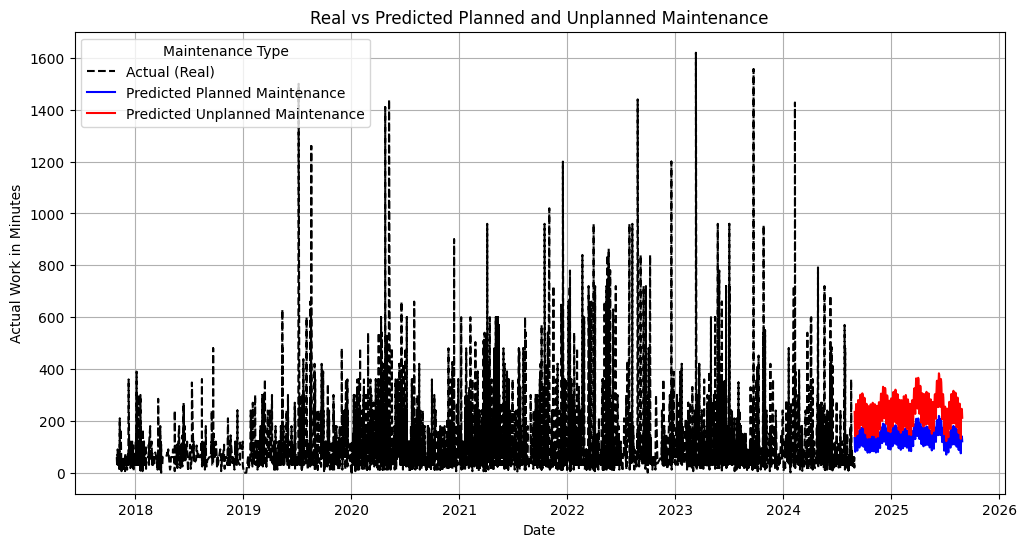

In [27]:
# Adjusting the plot to show a single line for real values and separate lines for predicted planned and unplanned


# Create plot
plt.figure(figsize=(12, 6))

# Plot real values as a single line
plt.plot(df_union[df_union['source'] == 'real']['ds'], df_union[df_union['source'] == 'real']['ACTUAL_WORK_IN_MINUTES'], 
         label='Actual (Real)', color='black', linestyle='--')

# Plot predicted planned maintenance
plt.plot(df_union[df_union['source'] == 'predicted']['ds'], df_union[df_union['source'] == 'predicted']['ACTUAL_WORK_IN_MINUTES'], 
         label='Predicted Planned Maintenance', color='blue')

# Plot predicted unplanned maintenance
plt.plot(df_union[df_union['source'] == 'predicted']['ds'], df_union[df_union['source'] == 'predicted']['ACTUAL_Unplanned'], 
         label='Predicted Unplanned Maintenance', color='red')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Actual Work in Minutes')
plt.title('Real vs Predicted Planned and Unplanned Maintenance')
plt.legend(title="Maintenance Type")
plt.grid(True)
plt.show()


In [28]:
df_union.head()

,ds,PRODUCTION_LOCATION,FUNCTIONAL_AREA_NODE_2_MODIFIED,MAINTENANCE_ACTIVITY_TYPE,EQUIPMENT_ID,ACTUAL_WORK_IN_MINUTES,ACTUAL_Unplanned,source
3725,2017-10-30,COTA,CAN LINE,Unplanned,300025792.0,60.0,NaN,real
1551,2017-10-30,COTA,CAN LINE,Unplanned,300025792.0,60.0,NaN,real
634,2017-10-31,COTA,CAN LINE,Unplanned,300025792.0,30.0,NaN,real
2442,2017-11-02,COTA,CAN LINE,Unplanned,300025792.0,90.0,NaN,real
1186,2017-11-02,COTA,CAN LINE,Unplanned,300025792.0,30.0,NaN,real


In [29]:
df_union['month_year'] = pd.to_datetime(df['EXECUTION_START_DATE']).dt.strftime('%Y-%m')

## Streamlit Filters

In [30]:
def find_plants():
    return df['PRODUCTION_LOCATION'].unique().tolist()


plants = find_plants()

Should The model be based on just selections made? i.e, if they want to see everything at a plant?